In [6]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
import lightning as L
from torch import nn
from dal_toolbox.datasets.base import BaseData
from dal_toolbox import metrics
from dal_toolbox.models import deterministic
import warnings
from sklearn.metrics import pairwise_kernels
from torch.utils.data import DataLoader

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data
    
def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_hparams_results_path(dataset, encoder, blr=0.075, bs=512, temp=0.1, ssl_model="simclr", rotation=None):
    if dataset == "SVHN":
        path = f"/mnt/stud/work/ynagel/results/self_supervised_learning/{dataset}_rotation_{rotation}/{ssl_model}_{encoder}/baselr_{blr}_bs_{bs}_temp_{temp}/"
    else:
        path = f"/mnt/stud/work/ynagel/results/self_supervised_learning/{dataset}/{ssl_model}_{encoder}/baselr_{blr}_bs_{bs}_temp_{temp}/"
    return Path(path)

path = create_hparams_results_path(dataset="CIFAR100", encoder="resnet18_deterministic")
print(path)
exp_results = get_experiments(Path(path), "seed*")
print(exp_results[0]["FinalLinearEvaluation"])

/mnt/stud/work/ynagel/results/self_supervised_learning/CIFAR100/simclr_resnet18_deterministic/baselr_0.075_bs_512_temp_0.1
{'final_train_acc': 0.8583333492279053, 'final_val_acc': 0.5992000102996826, 'final_test_acc': 0.6018999814987183}


In [8]:
datasets = ["SVHN", "CIFAR10", "CIFAR100"] # TODO Add other datasets
encoders = ["resnet18_deterministic", "resnet50_deterministic", "wide_resnet_28_10"]
learning_rates = ["0.025", "0.075", "0.125", "0.175"]
batch_sizes = ["512", "2048"]
temperatures = ["0.1", "0.5"]

encoder_names = {"resnet18_deterministic" : "ResNet18", "resnet50_deterministic" : "ResNet50", "wide_resnet_28_10" : "WideResNet2810"}

resnet18_deterministic 0.025 512 0.1 - 0.8416000008583069
resnet18_deterministic 0.025 512 0.5 - 0.8651999831199646
resnet18_deterministic 0.025 2048 0.1 - 0.8133999705314636
resnet18_deterministic 0.025 2048 0.5 - 0.8185999989509583
resnet18_deterministic 0.075 512 0.1 - 0.8853999972343445
resnet18_deterministic 0.075 512 0.5 - 0.9007999897003174
resnet18_deterministic 0.075 2048 0.1 - 0.8600000143051147
resnet18_deterministic 0.075 2048 0.5 - 0.8533999919891357
resnet18_deterministic 0.125 512 0.1 - 0.8859999775886536
resnet18_deterministic 0.125 512 0.5 - 0.9049999713897705
resnet18_deterministic 0.125 2048 0.1 - 0.8622000217437744
resnet18_deterministic 0.125 2048 0.5 - 0.8610000014305115
resnet18_deterministic 0.175 512 0.1 - 0.8845999836921692
resnet18_deterministic 0.175 512 0.5 - 0.9075999855995178
resnet18_deterministic 0.175 2048 0.1 - 0.8574000000953674
resnet18_deterministic 0.175 2048 0.5 - 0.8626000285148621
resnet50_deterministic 0.025 512 0.1 - 0.8741999864578247
resnet

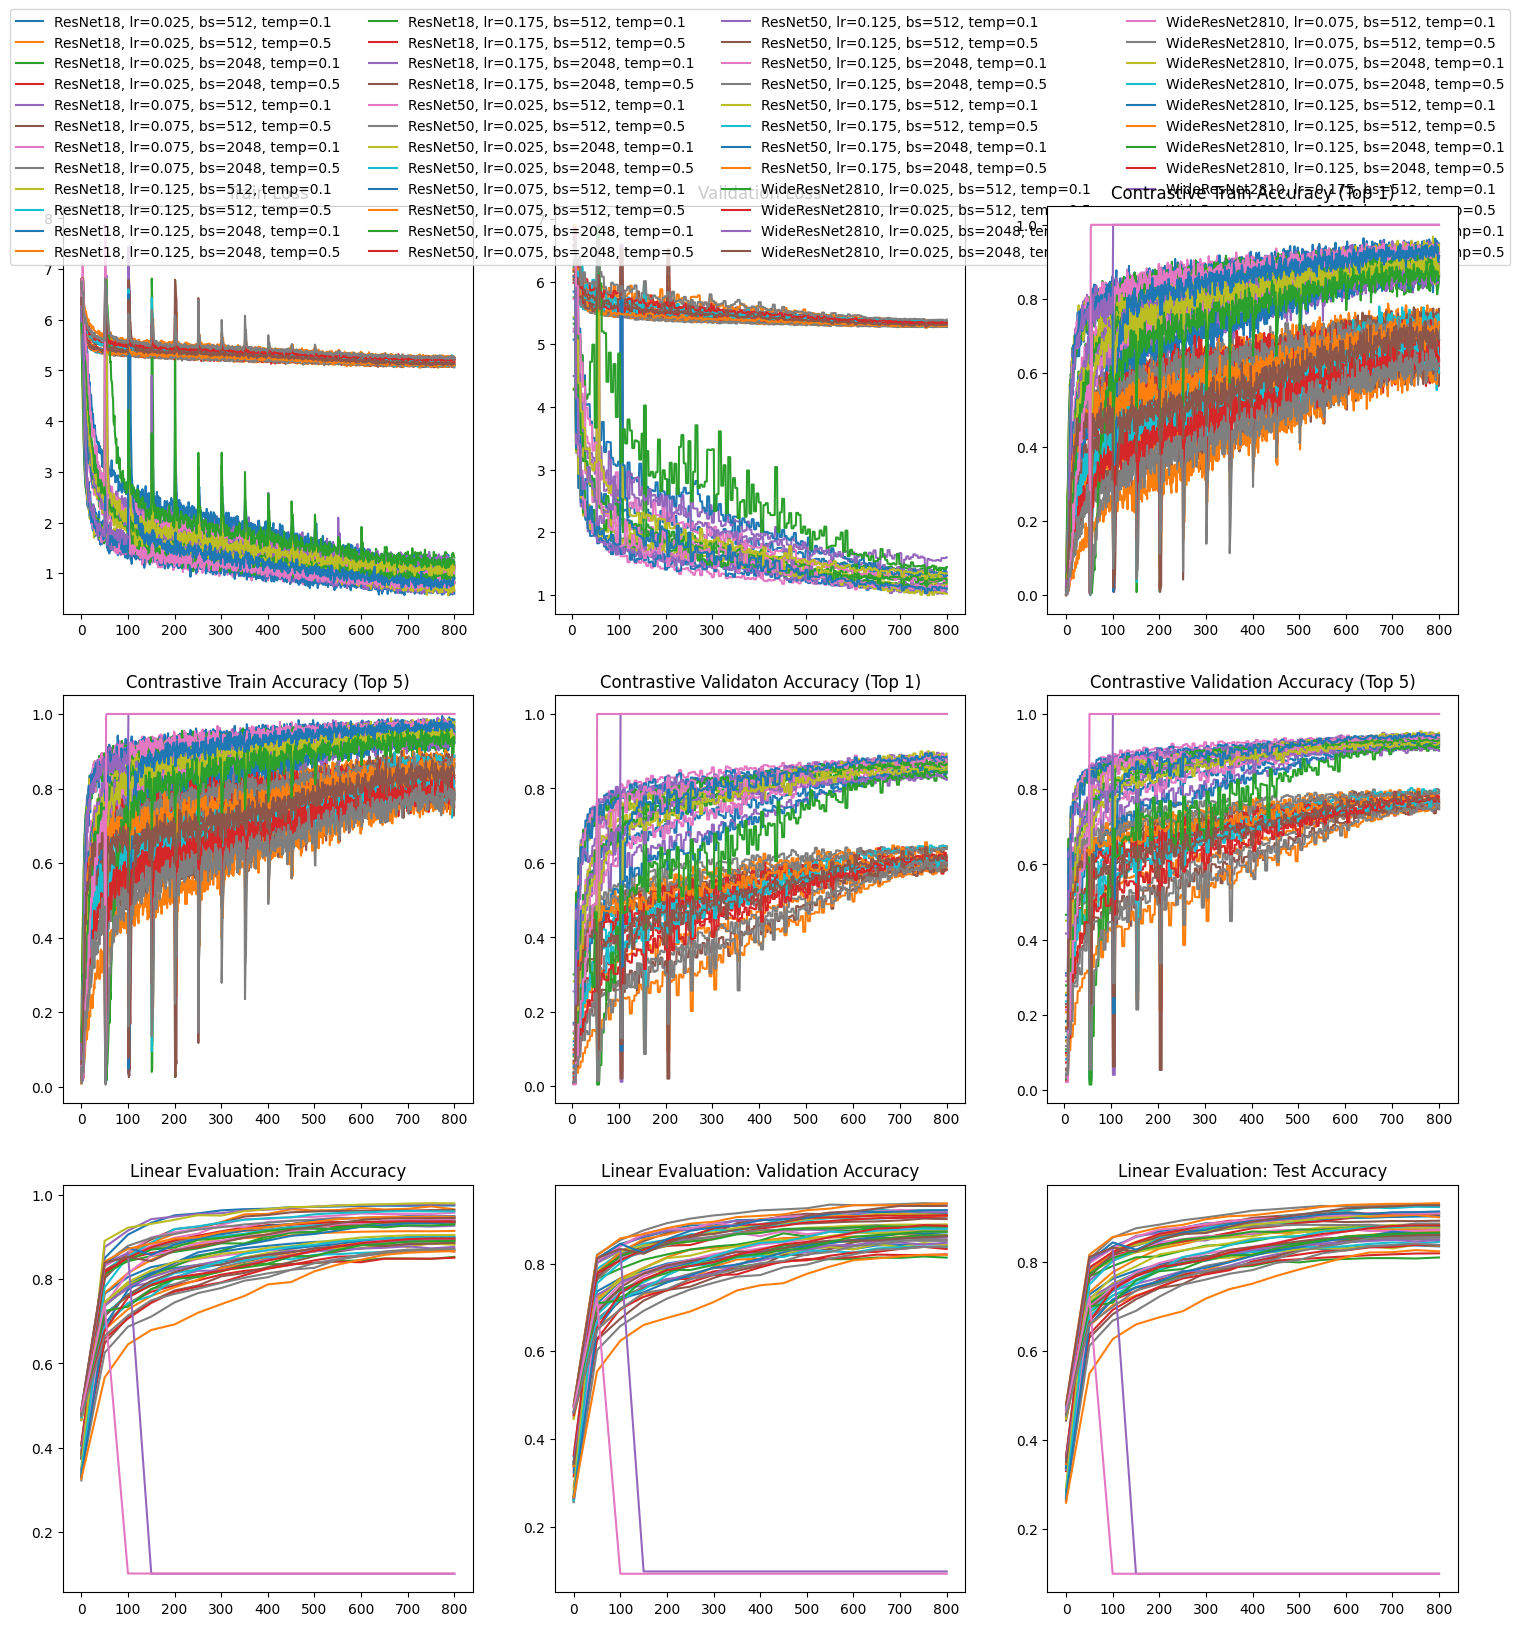

resnet18_deterministic 0.025 512 0.1 - 0.7093912363052368
resnet18_deterministic 0.025 512 0.5 - 0.8104013204574585
resnet18_deterministic 0.025 2048 0.1 - 0.7476112246513367
resnet18_deterministic 0.025 2048 0.5 - 0.7922468185424805
resnet18_deterministic 0.075 512 0.1 - 0.7136226892471313
resnet18_deterministic 0.075 512 0.5 - 0.8427518606185913
resnet18_deterministic 0.075 2048 0.1 - 0.7156702280044556
resnet18_deterministic 0.075 2048 0.5 - 0.8222768306732178
resnet18_deterministic 0.125 512 0.1 - 0.6740376949310303
resnet18_deterministic 0.125 512 0.5 - 0.8845208883285522
resnet18_deterministic 0.125 2048 0.1 - 0.7331422567367554
resnet18_deterministic 0.125 2048 0.5 - 0.8285558223724365
resnet18_deterministic 0.175 512 0.1 - 0.6740376949310303
resnet18_deterministic 0.175 512 0.5 - 0.8521703481674194
resnet18_deterministic 0.175 2048 0.1 - 0.6889162063598633
resnet18_deterministic 0.175 2048 0.5 - 0.8307398557662964
resnet50_deterministic 0.025 512 0.1 - 0.7620802521705627
resnet

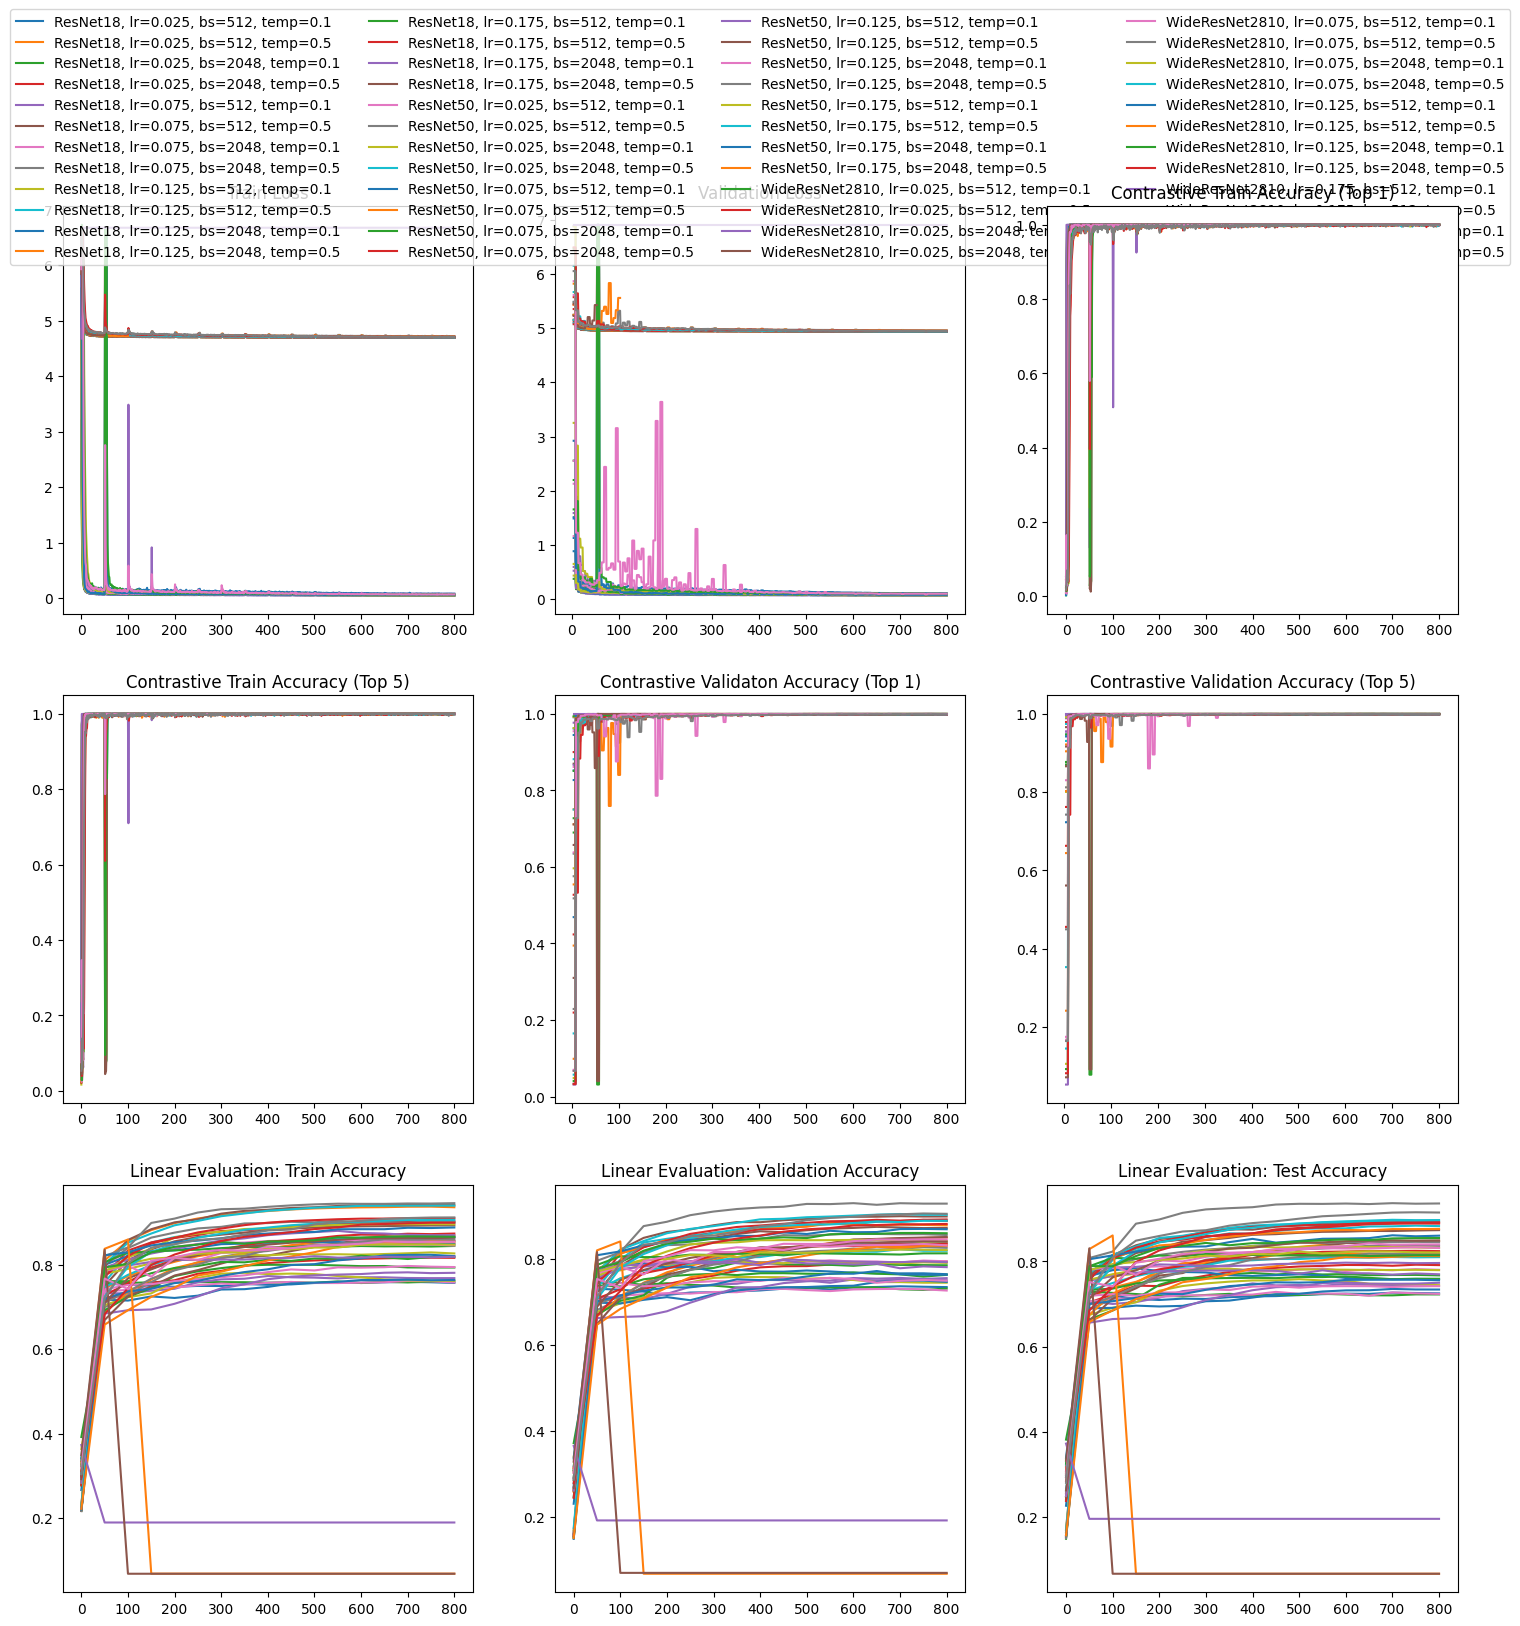

resnet18_deterministic 0.025 512 0.1 - 0.51419997215271
resnet18_deterministic 0.025 512 0.5 - 0.5771999955177307
resnet18_deterministic 0.025 2048 0.1 - 0.5461999773979187
resnet18_deterministic 0.025 2048 0.5 - 0.5270000100135803
resnet18_deterministic 0.075 512 0.1 - 0.5992000102996826
resnet18_deterministic 0.075 512 0.5 - 0.5938000082969666
resnet18_deterministic 0.075 2048 0.1 - 0.5860000252723694
resnet18_deterministic 0.075 2048 0.5 - 0.5658000111579895
resnet18_deterministic 0.125 512 0.1 - 0.6068000197410583
resnet18_deterministic 0.125 512 0.5 - 0.6126000285148621
resnet18_deterministic 0.125 2048 0.1 - 0.605400025844574
resnet18_deterministic 0.125 2048 0.5 - 0.5827999711036682
resnet18_deterministic 0.175 512 0.1 - 0.6144000291824341
resnet18_deterministic 0.175 512 0.5 - 0.598800003528595
resnet18_deterministic 0.175 2048 0.1 - 0.6051999926567078
resnet18_deterministic 0.175 2048 0.5 - 0.5774000287055969
resnet50_deterministic 0.025 512 0.1 - 0.6230000257492065
resnet50_d

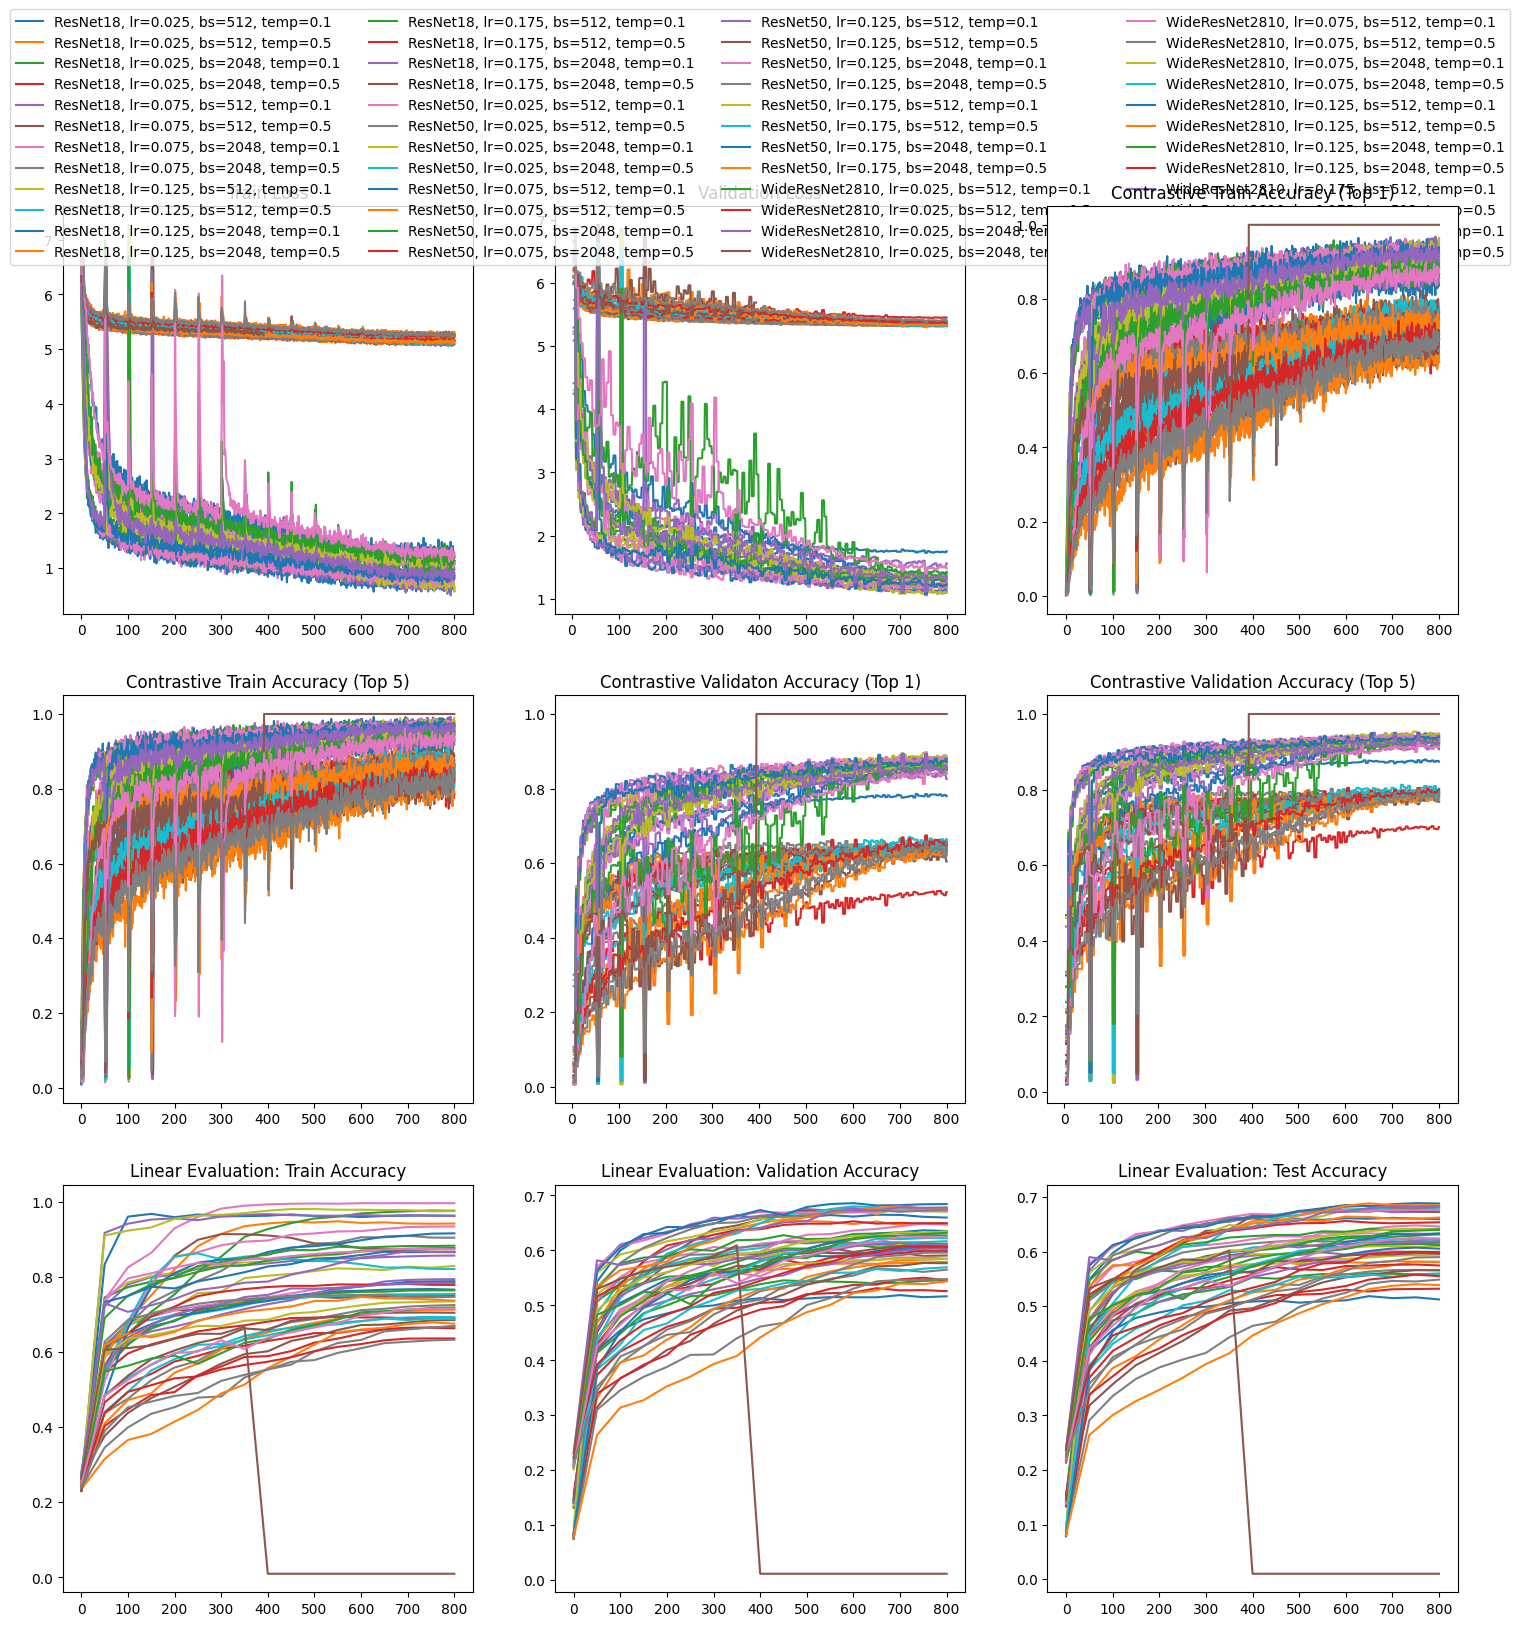

In [9]:
def plot_hparams_results(result_list, leg_cols=4):
    fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

    for result in result_list:
        x_axis = np.arange(0, len(result["SimCLR"]["train_loss"]))
        axis[0, 0].plot(x_axis, result["SimCLR"]["train_loss"])
        axis[0, 0].set_title("Train Loss")
        axis[0, 1].plot(x_axis, result["SimCLR"]["val_loss"], label=result["name"])
        axis[0, 1].set_title("Validation Loss")

        axis[0, 2].plot(x_axis, result["SimCLR"]["train_acc_top1"])
        axis[0, 2].set_title("Contrastive Train Accuracy (Top 1)")
        axis[1, 0].plot(x_axis, result["SimCLR"]["train_acc_top5"])
        axis[1, 0].set_title("Contrastive Train Accuracy (Top 5)")
        axis[1, 1].plot(x_axis, result["SimCLR"]["val_acc_top1"])
        axis[1, 1].set_title("Contrastive Validaton Accuracy (Top 1)")
        axis[1, 2].plot(x_axis, result["SimCLR"]["val_acc_top5"])
        axis[1, 2].set_title("Contrastive Validation Accuracy (Top 5)")

        x_axis = np.arange(0, len(result["SimCLR"]["train_loss"]), step=result["LinearEvaluation"]["interval"])
        axis[2, 0].plot(x_axis, result["LinearEvaluation"]["final_train_acc"])
        axis[2, 0].set_title("Linear Evaluation: Train Accuracy")
        axis[2, 1].plot(x_axis, result["LinearEvaluation"]["final_val_acc"])
        axis[2, 1].set_title("Linear Evaluation: Validation Accuracy")
        axis[2, 2].plot(x_axis, result["LinearEvaluation"]["final_test_acc"])
        axis[2, 2].set_title("Linear Evaluation: Test Accuracy")

    axis[0, 1].legend(loc="upper center", ncols=leg_cols, bbox_to_anchor=(0.5, 1.5))
    plt.show()

cifar10_iter_hparams = itertools.product(encoders, learning_rates, batch_sizes, temperatures)
cifar10_result_list = []
for encoder, lr, bs, temp  in cifar10_iter_hparams:
    print(encoder, lr, bs, temp, end=" - ")
    try:
        path = create_hparams_results_path(dataset="CIFAR10", encoder=encoder, blr=lr, bs=bs, temp=temp)
        dct = get_experiments(Path(path), "seed*")[0]
        dct["name"] =  f"{encoder_names[encoder]}, lr={lr}, bs={bs}, temp={temp}"
        dct["encoder"] =  encoder
        dct["lr"] =  lr
        dct["bs"] =  bs
        dct["temp"] =  temp
        print(dct["FinalLinearEvaluation"]["final_val_acc"])
        cifar10_result_list.append(dct)
    except FileNotFoundError:
        print("Missing")

plot_hparams_results(cifar10_result_list)

svhn_iter_hparams = itertools.product(encoders, learning_rates, batch_sizes, temperatures)
svhn_result_list = []
for encoder, lr, bs, temp  in svhn_iter_hparams:
    print(encoder, lr, bs, temp, end=" - ")
    try:
        path = create_hparams_results_path(dataset="SVHN", encoder=encoder, blr=lr, bs=bs, temp=temp, rotation=0.7)
        dct = get_experiments(Path(path), "seed*")[0]
        dct["name"] =  f"{encoder_names[encoder]}, lr={lr}, bs={bs}, temp={temp}"
        dct["encoder"] =  encoder
        dct["lr"] =  lr
        dct["bs"] =  bs
        dct["temp"] =  temp
        print(dct["FinalLinearEvaluation"]["final_val_acc"])
        svhn_result_list.append(dct)
    except FileNotFoundError:
        print("Missing")

plot_hparams_results(svhn_result_list)

cifar100_iter_hparams = itertools.product(encoders, learning_rates, batch_sizes, temperatures)
cifar100_result_list = []
for encoder, lr, bs, temp  in cifar100_iter_hparams:
    print(encoder, lr, bs, temp, end=" - ")
    try:
        path = create_hparams_results_path(dataset="CIFAR100", encoder=encoder, blr=lr, bs=bs, temp=temp)
        dct = get_experiments(Path(path), "seed*")[0]
        dct["name"] =  f"{encoder_names[encoder]}, lr={lr}, bs={bs}, temp={temp}"
        dct["encoder"] =  encoder
        dct["lr"] =  lr
        dct["bs"] =  bs
        dct["temp"] =  temp
        print(dct["FinalLinearEvaluation"]["final_val_acc"])
        cifar100_result_list.append(dct)
    except FileNotFoundError:
        print("Missing")

plot_hparams_results(cifar100_result_list)

In [10]:
cifar10_iter_hparams = itertools.product(encoders, learning_rates, temperatures)
for encoder, lr, temp  in cifar10_iter_hparams:
    bs512 = None
    bs2048 = None
    for element in cifar10_result_list:
        if element["encoder"] == encoder and element["lr"] == lr and element["temp"] == temp:
            if element["bs"] == "512":
                bs512 = element
            if element["bs"] == "2048":
                bs2048 = element

    print(f'{bs512["FinalLinearEvaluation"]["final_val_acc"]:.3f} vs. {bs2048["FinalLinearEvaluation"]["final_val_acc"]:.3f} --> Difference: {(bs512["FinalLinearEvaluation"]["final_val_acc"] - bs2048["FinalLinearEvaluation"]["final_val_acc"]):.3f}')

svhn_iter_hparams = itertools.product(encoders, learning_rates, temperatures)
for encoder, lr, temp  in svhn_iter_hparams:
    bs512 = None
    bs2048 = None
    for element in svhn_result_list:
        if element["encoder"] == encoder and element["lr"] == lr and element["temp"] == temp:
            if element["bs"] == "512":
                bs512 = element
            if element["bs"] == "2048":
                bs2048 = element

    print(f'{bs512["FinalLinearEvaluation"]["final_val_acc"]:.3f} vs. {bs2048["FinalLinearEvaluation"]["final_val_acc"]:.3f} --> Difference: {(bs512["FinalLinearEvaluation"]["final_val_acc"] - bs2048["FinalLinearEvaluation"]["final_val_acc"]):.3f}')

cifar100_iter_hparams = itertools.product(encoders, learning_rates, temperatures)
for encoder, lr, temp  in cifar100_iter_hparams:
    bs512 = None
    bs2048 = None
    for element in cifar100_result_list:
        if element["encoder"] == encoder and element["lr"] == lr and element["temp"] == temp:
            if element["bs"] == "512":
                bs512 = element
            if element["bs"] == "2048":
                bs2048 = element

    print(f'{bs512["FinalLinearEvaluation"]["final_val_acc"]:.3f} vs. {bs2048["FinalLinearEvaluation"]["final_val_acc"]:.3f} --> Difference: {(bs512["FinalLinearEvaluation"]["final_val_acc"] - bs2048["FinalLinearEvaluation"]["final_val_acc"]):.3f}')

0.842 vs. 0.813 --> Difference: 0.028
0.865 vs. 0.819 --> Difference: 0.047
0.885 vs. 0.860 --> Difference: 0.025
0.901 vs. 0.853 --> Difference: 0.047
0.886 vs. 0.862 --> Difference: 0.024
0.905 vs. 0.861 --> Difference: 0.044
0.885 vs. 0.857 --> Difference: 0.027
0.908 vs. 0.863 --> Difference: 0.045
0.874 vs. 0.840 --> Difference: 0.034
0.887 vs. 0.838 --> Difference: 0.048
0.915 vs. 0.863 --> Difference: 0.051
0.907 vs. 0.837 --> Difference: 0.070
0.919 vs. 0.878 --> Difference: 0.041
0.918 vs. 0.835 --> Difference: 0.083
0.912 vs. 0.870 --> Difference: 0.042
0.919 vs. 0.821 --> Difference: 0.098
0.885 vs. 0.844 --> Difference: 0.041
0.909 vs. 0.861 --> Difference: 0.047
0.917 vs. 0.874 --> Difference: 0.043
0.936 vs. 0.877 --> Difference: 0.059
0.921 vs. 0.874 --> Difference: 0.047
0.937 vs. 0.886 --> Difference: 0.052
0.098 vs. 0.093 --> Difference: 0.005
0.929 vs. 0.855 --> Difference: 0.074
0.709 vs. 0.748 --> Difference: -0.038
0.810 vs. 0.792 --> Difference: 0.018
0.714 vs. 0

Best CIFAR10 Result: WideResNet2810, lr=0.125, bs=512, temp=0.5 --> Train Accuracy: 0.9471 (0.9486), Validation Accuracy: 0.9374 (0.9372), Test Accuracy: 0.9334 (0.9328)


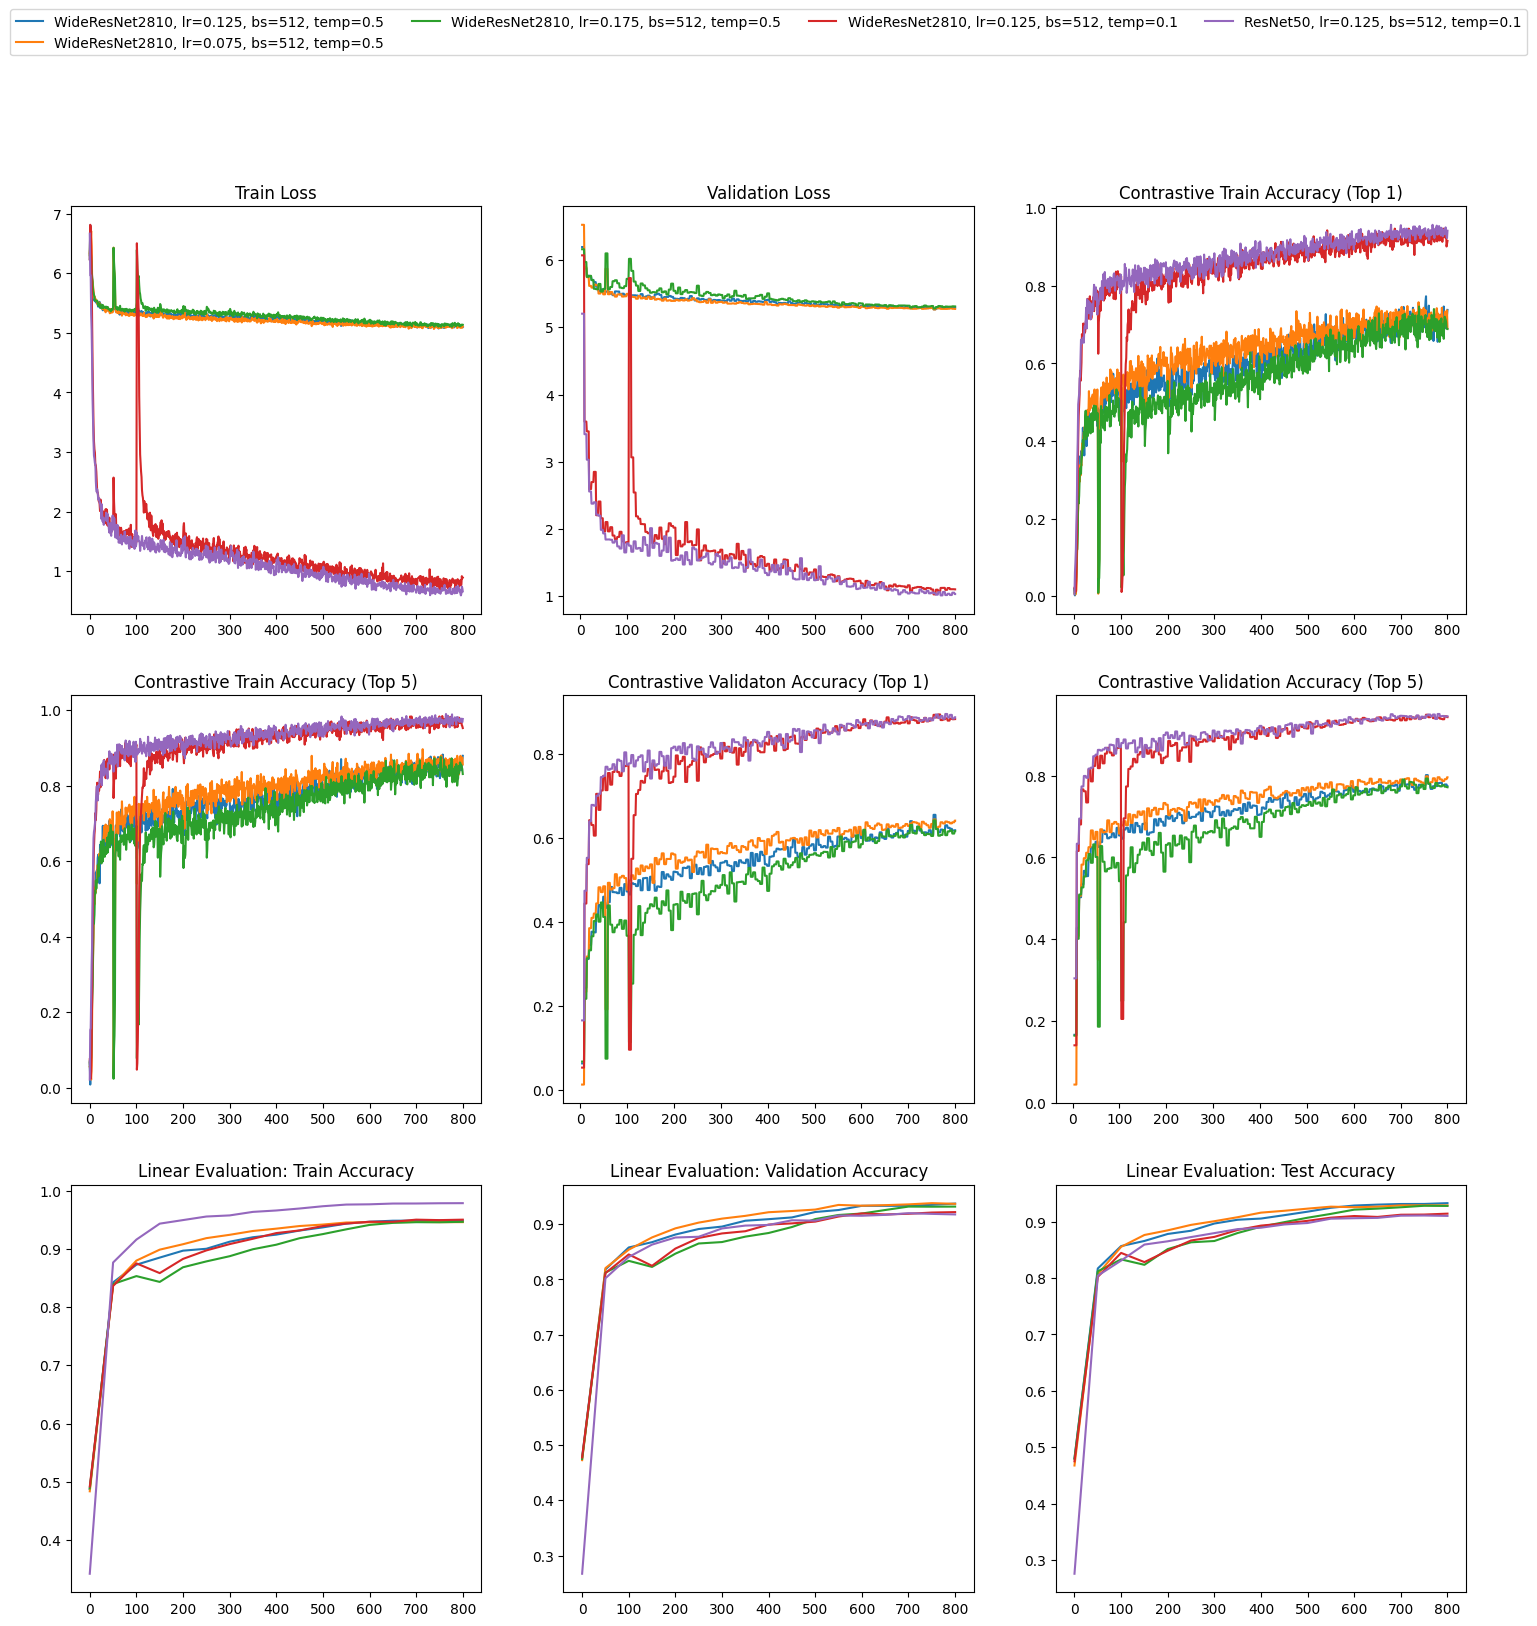

Best SVHN Result: WideResNet2810, lr=0.075, bs=512, temp=0.5 --> Train Accuracy: 0.9326 (0.9467), Validation Accuracy: 0.9049 (0.9292), Test Accuracy: 0.9058 (0.9361)


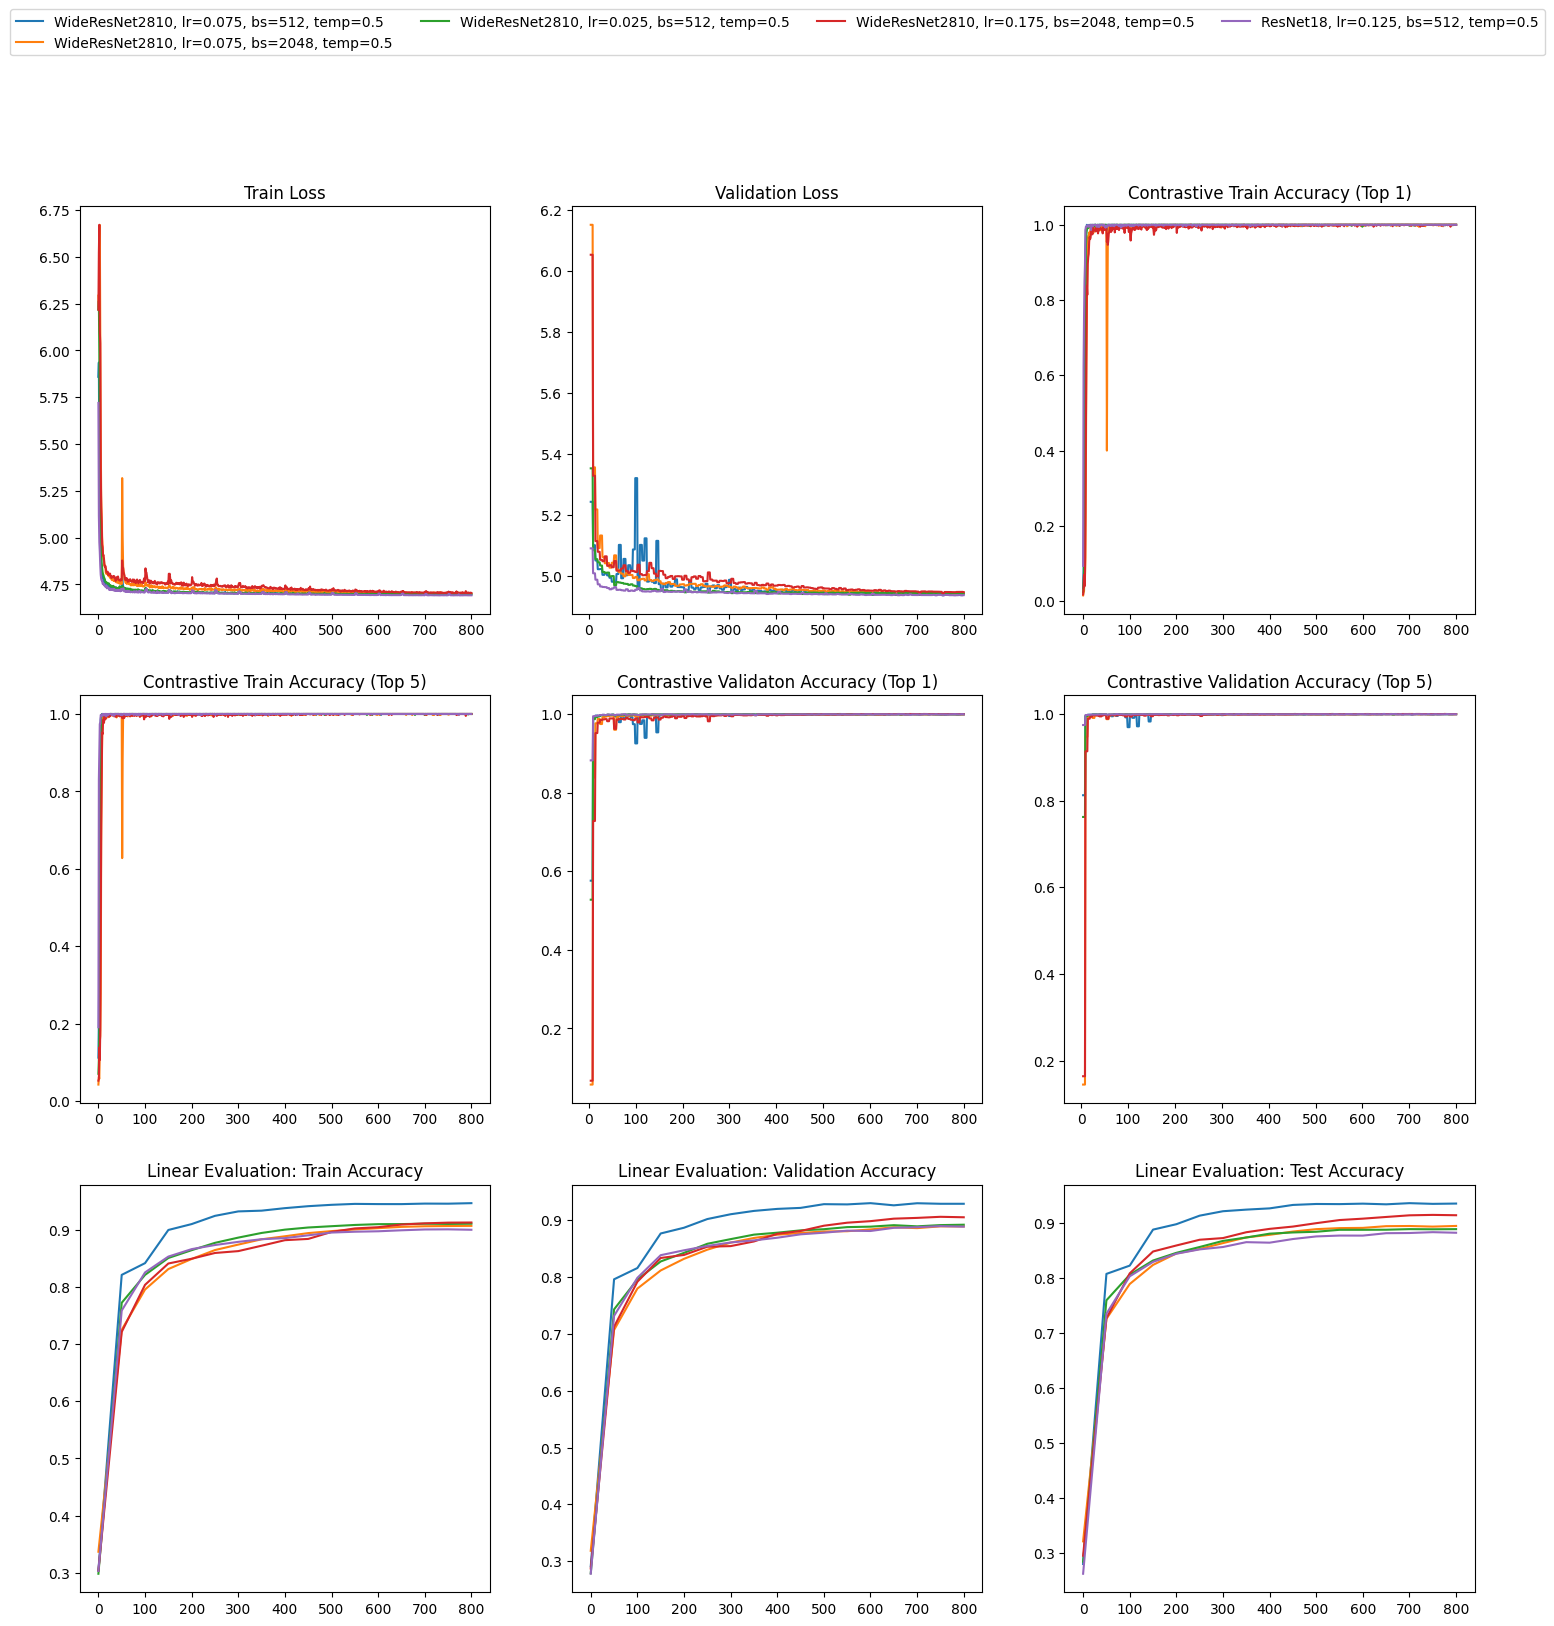

Best CIFAR100 Result: WideResNet2810, lr=0.125, bs=512, temp=0.5 --> Train Accuracy: 0.7424 (0.7380), Validation Accuracy: 0.6820 (0.6778), Test Accuracy: 0.6885 (0.6855)


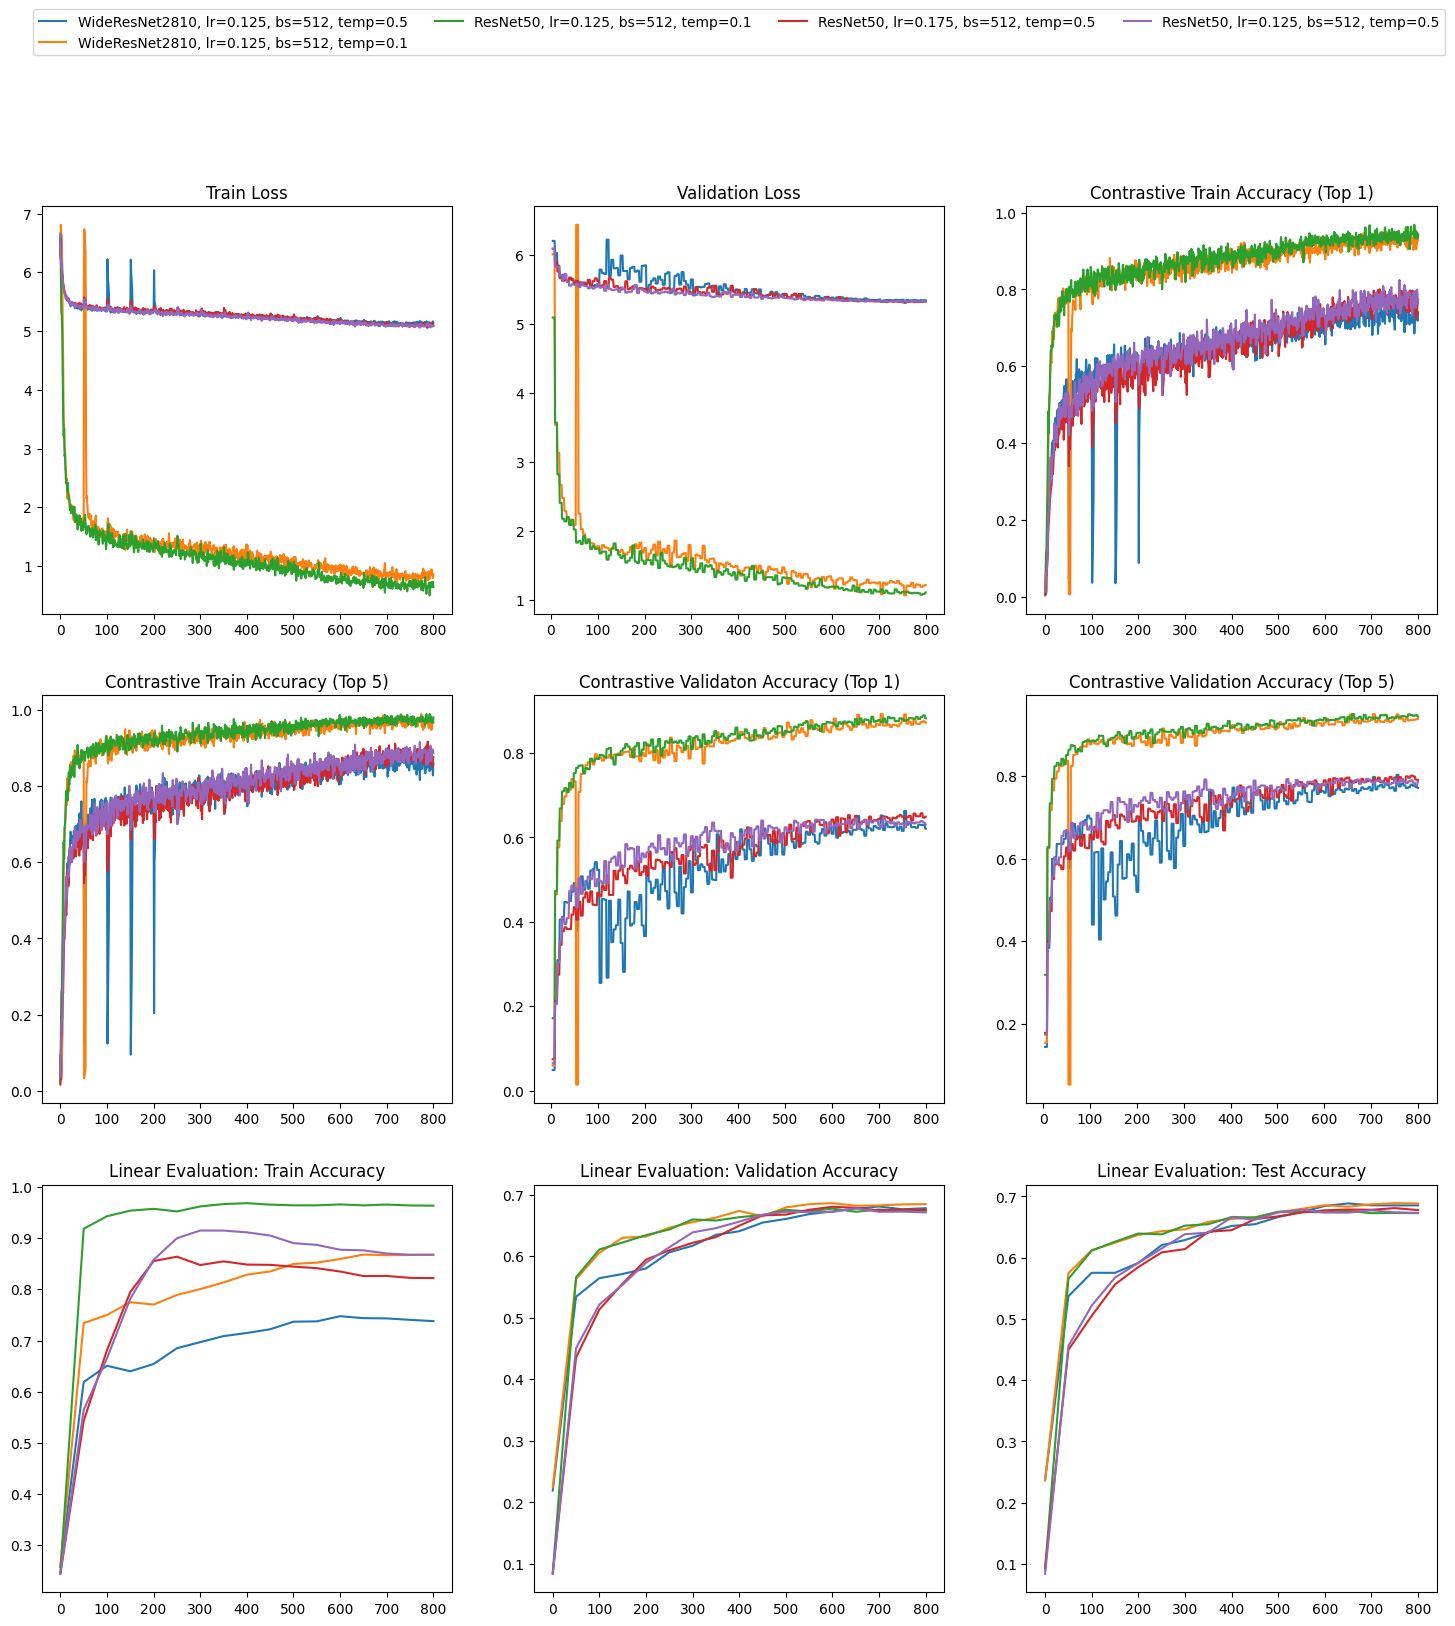

WideResNet2810, lr=0.075, bs=512, temp=0.5
0.9372000098228455
0.6805999875068665


In [11]:
def get_top_x_from_results_list(lst, topk=5):
    return sorted(lst, key=lambda x: x["FinalLinearEvaluation"]["final_val_acc"], reverse=True)[:topk]

def get_top_x_from_results_list_le(lst, topk=5):
    return sorted(lst, key=lambda x: x["LinearEvaluation"]["final_val_acc"][-1], reverse=True)[:topk]

sorted_cifar10_results_list = get_top_x_from_results_list(cifar10_result_list, topk=5)
best_cifar10_result = sorted_cifar10_results_list[0]
print(f"Best CIFAR10 Result: {best_cifar10_result['name']} --> Train Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_train_acc']:.4f} ({best_cifar10_result['LinearEvaluation']['final_train_acc'][-1]:.4f}), "
                                                        f"Validation Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_val_acc']:.4f} ({best_cifar10_result['LinearEvaluation']['final_val_acc'][-1]:.4f}), "
                                                        f"Test Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_test_acc']:.4f} ({best_cifar10_result['LinearEvaluation']['final_test_acc'][-1]:.4f})")
plot_hparams_results(sorted_cifar10_results_list)

sorted_svhn_results_list = get_top_x_from_results_list(svhn_result_list, topk=5)
best_svhn_result = sorted_svhn_results_list[0]
print(f"Best SVHN Result: {best_svhn_result['name']} --> Train Accuracy: {best_svhn_result['FinalLinearEvaluation']['final_train_acc']:.4f} ({best_svhn_result['LinearEvaluation']['final_train_acc'][-1]:.4f}), "
                                                        f"Validation Accuracy: {best_svhn_result['FinalLinearEvaluation']['final_val_acc']:.4f} ({best_svhn_result['LinearEvaluation']['final_val_acc'][-1]:.4f}), "
                                                        f"Test Accuracy: {best_svhn_result['FinalLinearEvaluation']['final_test_acc']:.4f} ({best_svhn_result['LinearEvaluation']['final_test_acc'][-1]:.4f})")
plot_hparams_results(sorted_svhn_results_list)

sorted_cifar100_results_list = get_top_x_from_results_list(cifar100_result_list, topk=5)
best_cifar100_result = sorted_cifar100_results_list[0]
print(f"Best CIFAR100 Result: {best_cifar100_result['name']} --> Train Accuracy: {best_cifar100_result['FinalLinearEvaluation']['final_train_acc']:.4f} ({best_cifar100_result['LinearEvaluation']['final_train_acc'][-1]:.4f}), "
                                                        f"Validation Accuracy: {best_cifar100_result['FinalLinearEvaluation']['final_val_acc']:.4f} ({best_cifar100_result['LinearEvaluation']['final_val_acc'][-1]:.4f}), "
                                                        f"Test Accuracy: {best_cifar100_result['FinalLinearEvaluation']['final_test_acc']:.4f} ({best_cifar100_result['LinearEvaluation']['final_test_acc'][-1]:.4f})")
plot_hparams_results(sorted_cifar100_results_list)

print(get_top_x_from_results_list_le(svhn_result_list, topk=1)[0]['name'])
print(max(best_cifar10_result['LinearEvaluation']['final_val_acc']))
print(max(best_cifar100_result['LinearEvaluation']['final_val_acc']))

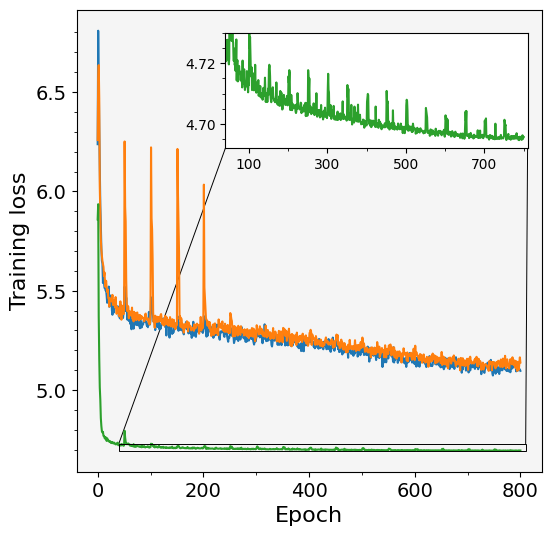

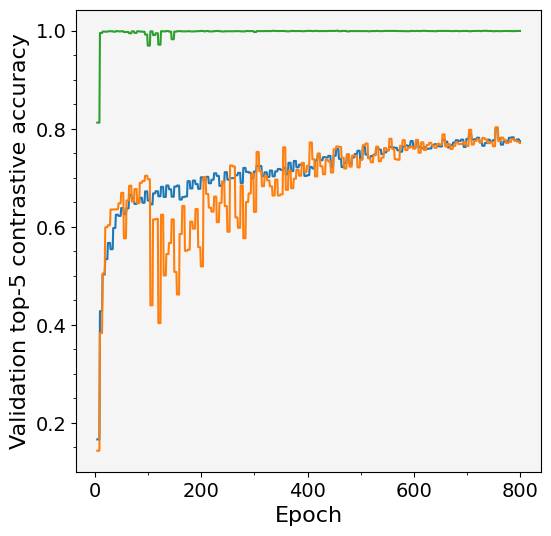

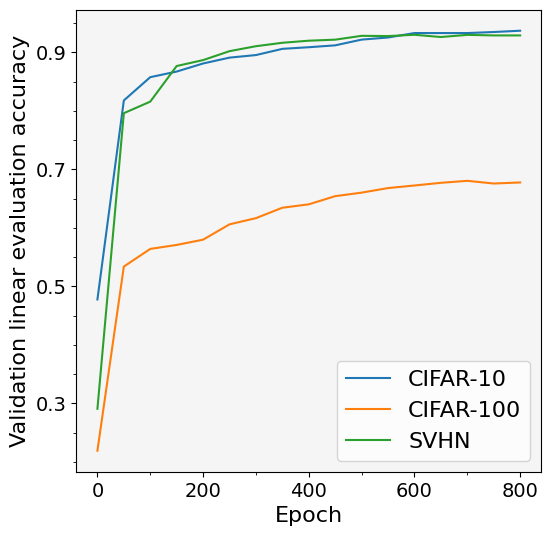

In [12]:
best_results = [best_cifar10_result, best_cifar100_result, best_svhn_result]
best_results_name = ["CIFAR-10", "CIFAR-100", "SVHN"]

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
x1,x2,y1,y2 = 40, 810, 4.692, 4.73
axin = ax.inset_axes(
    [0.32, 0.7, 0.65, 0.25],
    xlim=(x1, x2), ylim=(y1, y2))
axin.set_xticks([100, 300, 500, 700])
axin.set_xticks([200, 400, 600, 800], minor=True)
axin.set_yticks([4.7, 4.72,])
axin.set_yticks(np.arange(4.695, 4.73, 0.005), minor=True)
for res, name in zip(best_results, best_results_name):
    x_axis = np.arange(0, len(res["SimCLR"]["train_loss"]))
    plt.plot(x_axis, res["SimCLR"]["train_loss"], label=name)
    axin.plot(x_axis, res["SimCLR"]["train_loss"], label=name)
#plt.title("Training loss")
plt.xlabel("Epoch", size=16)
plt.ylabel("Training loss", size=16)
plt.xticks(np.arange(0, 801, 200), size=14)
plt.xticks(np.arange(100, 701, 200), minor=True)
plt.yticks(np.arange(5.0, 6.51, 0.5), size=14)
plt.yticks(np.arange(4.7, 6.81, 0.1), minor=True)
#ax.indicate_inset_zoom(axin, edgecolor="black")

from matplotlib.patches import ConnectionPatch
rect = (x1, y1, x2 - x1, y2 - y1)
box = ax.indicate_inset(rect, edgecolor="black", alpha=1, lw=0.7)
cp1 = ConnectionPatch(xyA=(40, 4.73), xyB=(0, 0), axesA=ax, axesB=axin,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls="-")
cp2 = ConnectionPatch(xyA=(810, 4.73), xyB=(1, 0), axesA=ax, axesB=axin,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls="-")
ax.add_patch(cp1)
ax.add_patch(cp2)

ax.set_facecolor('whitesmoke')
plt.savefig("ssl_train_loss.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6, 6))
for res, name in zip(best_results, best_results_name):
    x_axis = np.arange(0, len(res["SimCLR"]["val_acc_top5"]))
    plt.plot(x_axis, res["SimCLR"]["val_acc_top5"], label=name)
#plt.title("Training loss")
plt.xlabel("Epoch", size=16)
plt.ylabel("Validation top-5 contrastive accuracy", size=16)
plt.xticks(np.arange(0, 801, 200), size=14)
plt.xticks(np.arange(100, 701, 200), minor=True)
plt.yticks(np.arange(0.2, 1.01, 0.2), size=14)
plt.yticks(np.arange(0.15, 1.01, 0.05), minor=True)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.savefig("ssl_top5_ca.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6, 6))
for res, name in zip(best_results, best_results_name):
    x_axis = np.arange(0, len(res["SimCLR"]["train_loss"]), step=res["LinearEvaluation"]["interval"])
    plt.plot(x_axis, res["LinearEvaluation"]["final_val_acc"], label=name)
#plt.title("Training loss")
plt.xlabel("Epoch", size=16)
plt.ylabel("Validation linear evaluation accuracy", size=16)
plt.xticks(np.arange(0, 801, 200), size=14)
plt.xticks(np.arange(100, 701, 200), minor=True)
plt.yticks(np.arange(0.3, 0.91, 0.2), size=14)
plt.yticks(np.arange(0.2, 0.951, 0.05), minor=True)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.legend(fontsize=16)
plt.savefig("ssl_le_acc.pdf", bbox_inches="tight")
plt.show()

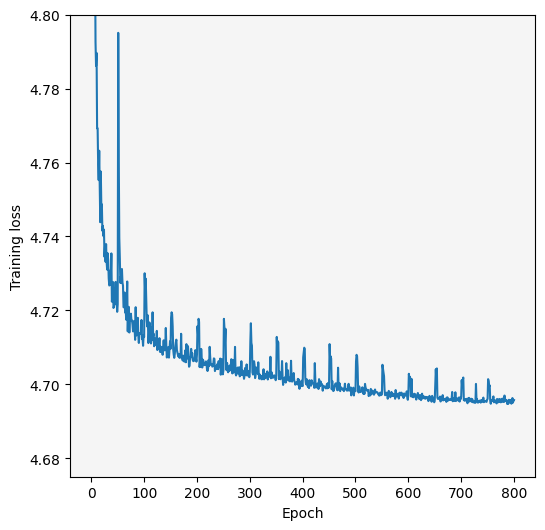

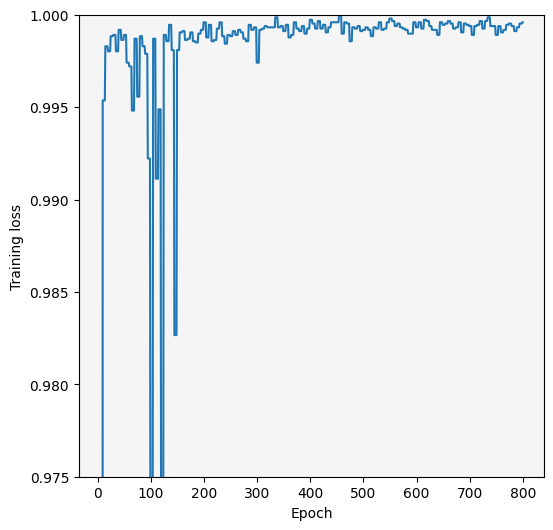

In [13]:
fig = plt.figure(figsize=(6, 6))
x_axis = np.arange(0, len(best_svhn_result["SimCLR"]["train_loss"]))
plt.plot(x_axis, res["SimCLR"]["train_loss"], label=name)
#plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.ylim((4.675, 4.8))
# plt.savefig("ssl_train_loss.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6, 6))
x_axis = np.arange(0, len(best_svhn_result["SimCLR"]["val_acc_top5"]))
plt.plot(x_axis, res["SimCLR"]["val_acc_top5"], label=name)
#plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.ylim((0.975, 1.0))
# plt.savefig("ssl_train_loss.pdf", bbox_inches="tight")
plt.show()

In [14]:
from dal_toolbox.datasets.utils import FeatureDataset, FeatureDatasetWrapper

best_paths = create_hparams_results_path(dataset="CIFAR10", encoder=best_cifar10_result['encoder'], blr=best_cifar10_result['lr'], bs=best_cifar10_result['bs'], temp=best_cifar10_result['temp']).glob("seed*")
for i, best_path in enumerate(best_paths): # Should only be one
    assert i == 0, "Shoudl only be one best path"
    best_path = Path(str(best_path) +  f"/{best_cifar10_result['encoder']}_CIFAR10_{best_cifar10_result['FinalLinearEvaluation']['final_val_acc']:.3f}.pth")
    cifar10_data = FeatureDatasetWrapper(best_path)

In [30]:
import sys
from dal_toolbox.utils import kernels, _calculate_mean_gamma
from scipy.stats import skew

trainset = cifar10_data.train_dataset
features = torch.stack([batch[0] for batch in trainset])
gamma = _calculate_mean_gamma(features)
print(f"Calculated gamma: {gamma:.2e} ({gamma})")
S = kernels(X=features, Y=features, metric="rbf", gamma=gamma)
print(f"Shape of S: {S.shape}, Memory Usage: {sys.getsizeof(S) * 1e-09} GB")
np.fill_diagonal(S, np.nan)

min = np.nanmin(S)
print(f"Min similarity: {min:.2e} ({min})")
max = np.nanmax(S)
print(f"Max similarity: {max:.2e} ({max})")
mean=np.nanmean(S)
print(f"Mean similarity: {mean:.2e} ({mean})")

quantiles = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
quantile_names = ["0.10-Quantile", "0.25-Quantile", "0.33-Quantile", "Median", "0.66-Quantile", "0.75-Quantile", "0.90-Quantile", ]

quantile_values=np.nanquantile(S, quantiles)

for value, name in zip(quantile_values, quantile_names):
    print(f"{name} similarity: {value:.2e} ({value})")

skew_=skew(S, axis=None, nan_policy="omit", bias=False)
print(f"Fisher-Pearson coefficient of skewness: {skew_}")

Calculated gamma: 3.55e-01 (0.35514930807128064)
Shape of S: (45000, 45000), Memory Usage: 8.100000128000001 GB
Min similarity: 0.00e+00 (0.0)
Max similarity: 9.65e-01 (0.9648251533508301)
Mean similarity: 1.88e-03 (0.0018757751677185297)
Median similarity: 3.19e-07 (3.1883277529232146e-07)
[1.32415245e-16 2.66293116e-11 1.11815313e-09 3.18832775e-07
 1.43840825e-05 9.36674624e-05 2.18175119e-03]
0.10-Quantile similarity: 1.32e-16 (1.3241524451105608e-16)
0.25-Quantile similarity: 2.66e-11 (2.66293116030214e-11)
0.33-Quantile similarity: 1.12e-09 (1.1181531256454491e-09)
Median similarity: 3.19e-07 (3.1883277529232146e-07)
0.66-Quantile similarity: 1.44e-05 (1.4384082533069886e-05)
0.75-Quantile similarity: 9.37e-05 (9.366746235173196e-05)
0.90-Quantile similarity: 2.18e-03 (0.002181751187890768)
Fisher-Pearson coefficient of skewness: 13.584176063537598


In [ ]:
#idx = np.random.randint(0, 45000, 10000)

#slice = S[idx]
#slice = slice[:, idx]
#print(slice.shape)
#print(f"{slice.shape[0] * slice.shape[1]:.3e} Elements in matrix")

#plt.hist(slice.flat, bins=300)
#plt.title("CIFAR10 Similarity (Without Self.similarity)")
#plt.yscale("log")
# plt.xlim(0, 0.05)
#plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
#plt.show()

In [31]:
best_paths = create_hparams_results_path(dataset="SVHN", encoder=best_svhn_result['encoder'], blr=best_svhn_result['lr'], bs=best_svhn_result['bs'], temp=best_svhn_result['temp'], rotation="0.7").glob("seed*")
for i, best_path in enumerate(best_paths): # Should only be one
    assert i == 0, "Should only be one best path"
    best_path = Path(str(best_path) +  f"/{best_svhn_result['encoder']}_SVHN_{best_svhn_result['FinalLinearEvaluation']['final_val_acc']:.3f}.pth")
    svhn_data = FeatureDatasetWrapper(best_path)

In [32]:
trainset = svhn_data.train_dataset
features = torch.stack([batch[0] for batch in trainset])
gamma = _calculate_mean_gamma(features)
print(f"Calculated gamma: {gamma:.2e} ({gamma})")
S = kernels(X=features, Y=features, metric="rbf", gamma=gamma)
print(f"Shape of S: {S.shape}, Memory Usage: {sys.getsizeof(S) * 1e-09} GB")
np.fill_diagonal(S, np.nan)

min = np.nanmin(S)
print(f"Min similarity: {min:.2e} ({min})")
max = np.nanmax(S)
print(f"Max similarity: {max:.2e} ({max})")
mean=np.nanmean(S)
print(f"Mean similarity: {mean:.2e} ({mean})")

quantiles = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
quantile_names = ["0.10-Quantile", "0.25-Quantile", "0.33-Quantile", "Median", "0.66-Quantile", "0.75-Quantile", "0.90-Quantile", ]

quantile_values=np.nanquantile(S, quantiles)

for value, name in zip(quantile_values, quantile_names):
    print(f"{name} similarity: {value:.2e} ({value})")

skew_=skew(S, axis=None, nan_policy="omit", bias=False)
print(f"Fisher-Pearson coefficient of skewness: {skew_}")

Calculated gamma: 1.12e-03 (0.0011244404831876552)
Shape of S: (65931, 65931), Memory Usage: 17.387587172 GB
Min similarity: 1.82e-32 (1.821808328211244e-32)
Max similarity: 1.00e+00 (1.0)
Mean similarity: 2.79e-04 (0.00027851873892359436)
Median similarity: 6.59e-09 (6.593263712773023e-09)
[2.29755581e-12 1.08085020e-10 4.58674709e-10 6.59326371e-09
 7.64928672e-08 3.54051423e-07 1.12473381e-05]
0.10-Quantile similarity: 2.30e-12 (2.297555808800089e-12)
0.25-Quantile similarity: 1.08e-10 (1.080850201007344e-10)
0.33-Quantile similarity: 4.59e-10 (4.586747093249244e-10)
Median similarity: 6.59e-09 (6.593263712773023e-09)
0.66-Quantile similarity: 7.65e-08 (7.649286715150083e-08)
0.75-Quantile similarity: 3.54e-07 (3.5405142284616886e-07)
0.90-Quantile similarity: 1.12e-05 (1.1247338079556357e-05)
Fisher-Pearson coefficient of skewness: 50.52949142456055


In [33]:
best_paths = create_hparams_results_path(dataset="CIFAR100", encoder=best_cifar100_result['encoder'], blr=best_cifar100_result['lr'], bs=best_cifar100_result['bs'], temp=best_cifar100_result['temp']).glob("seed*")
for i, best_path in enumerate(best_paths): # Should only be one
    assert i == 0, "Should only be one best path"
    best_path = Path(str(best_path) +  f"/{best_cifar100_result['encoder']}_CIFAR100_{best_cifar100_result['FinalLinearEvaluation']['final_val_acc']:.3f}.pth")
    cifar100_data = FeatureDatasetWrapper(best_path)

In [34]:
trainset = cifar100_data.train_dataset
features = torch.stack([batch[0] for batch in trainset])
gamma = _calculate_mean_gamma(features)
print(f"Calculated gamma: {gamma:.2e} ({gamma})")
S = kernels(X=features, Y=features, metric="rbf", gamma=gamma)
print(f"Shape of S: {S.shape}, Memory Usage: {sys.getsizeof(S) * 1e-09} GB")
np.fill_diagonal(S, np.nan)

min = np.nanmin(S)
print(f"Min similarity: {min:.2e} ({min})")
max = np.nanmax(S)
print(f"Max similarity: {max:.2e} ({max})")
mean=np.nanmean(S)
print(f"Mean similarity: {mean:.2e} ({mean})")

quantiles = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
quantile_names = ["0.10-Quantile", "0.25-Quantile", "0.33-Quantile", "Median", "0.66-Quantile", "0.75-Quantile", "0.90-Quantile", ]

quantile_values=np.nanquantile(S, quantiles)

for value, name in zip(quantile_values, quantile_names):
    print(f"{name} similarity: {value:.2e} ({value})")

skew_=skew(S, axis=None, nan_policy="omit", bias=False)
print(f"Fisher-Pearson coefficient of skewness: {skew_}")

Calculated gamma: 3.81e-01 (0.38105176008780417)
Shape of S: (45000, 45000), Memory Usage: 8.100000128000001 GB
Min similarity: 0.00e+00 (0.0)
Max similarity: 1.00e+00 (1.0)
Mean similarity: 2.06e-03 (0.0020569132175296545)
0.10-Quantile similarity: 3.88e-17 (3.877051117573204e-17)
0.25-Quantile similarity: 1.27e-10 (1.2717880915058544e-10)
0.33-Quantile similarity: 6.24e-09 (6.239103012006808e-09)
Median similarity: 1.47e-06 (1.473734982937458e-06)
0.66-Quantile similarity: 4.90e-05 (4.9018759455066174e-05)
0.75-Quantile similarity: 2.50e-04 (0.0002497770474292338)
0.90-Quantile similarity: 3.43e-03 (0.003433977486565709)
Fisher-Pearson coefficient of skewness: 13.150524139404297


In [35]:
best_path = Path("/mnt/stud/home/ynagel/data/vits14_reg_ImageNet100_norm.pth")
imagenet100_data = FeatureDatasetWrapper(best_path)

In [42]:
trainset = imagenet100_data.train_dataset
features = torch.stack([batch[0] for batch in trainset])
gamma = _calculate_mean_gamma(features)
print(f"Calculated gamma: {gamma:.2e} ({gamma})")
idx = np.random.randint(0, 115690, 80000)
features = features[idx]
S = kernels(X=features, Y=features, metric="rbf", gamma=gamma)
print(f"Shape of S: {S.shape}, Memory Usage: {sys.getsizeof(S) * 1e-09} GB")
np.fill_diagonal(S, np.nan)

min = np.nanmin(S)
print(f"Min similarity: {min:.2e} ({min})")
max = np.nanmax(S)
print(f"Max similarity: {max:.2e} ({max})")
mean=np.nanmean(S)
print(f"Mean similarity: {mean:.2e} ({mean})")

quantiles = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
quantile_names = ["0.10-Quantile", "0.25-Quantile", "0.33-Quantile", "Median", "0.66-Quantile", "0.75-Quantile", "0.90-Quantile", ]

quantile_values=np.nanquantile(S, quantiles)

for value, name in zip(quantile_values, quantile_names):
    print(f"{name} similarity: {value:.2e} ({value})")

skew_=skew(S, axis=None, nan_policy="omit", bias=False)
print(f"Fisher-Pearson coefficient of skewness: {skew_}")

Calculated gamma: 1.49e-02 (0.014926557833282996)
Shape of S: (80000, 80000), Memory Usage: 25.600000128 GB
Min similarity: 4.22e-13 (4.215762125243244e-13)
Max similarity: 1.00e+00 (1.0)
Mean similarity: 2.56e-05 (2.5595611077733338e-05)
0.10-Quantile similarity: 5.51e-10 (5.513448031457813e-10)
0.25-Quantile similarity: 1.31e-09 (1.3093470752068015e-09)
0.33-Quantile similarity: 1.83e-09 (1.8343471186454963e-09)
Median similarity: 3.50e-09 (3.4973639539970236e-09)
0.66-Quantile similarity: 6.60e-09 (6.59588028639746e-09)
0.75-Quantile similarity: 1.01e-08 (1.0124031391001154e-08)
0.90-Quantile similarity: 3.16e-08 (3.161885686608912e-08)
Fisher-Pearson coefficient of skewness: 293.34765625


In [ ]:
#idx = np.random.randint(0, 45000, 10000)

#slice = S[idx]
#slice = slice[:, idx]
#print(slice.shape)
#print(f"{slice.shape[0] * slice.shape[1]:.3e} Elements in matrix")

#plt.hist(slice.flat, bins=300)
#plt.title("CIFAR10 Similarity (Without Self.similarity)")
#plt.yscale("log")
# plt.xlim(0, 0.05)
#plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
#plt.show()

In [ ]:
plt.hist(np.nanmean(S, axis=0), bins=50)
plt.title("CIFAR10 Mean Similarity (axis=0) (Without Self.similarity)")
plt.show()

In [ ]:
idx = np.random.randint(0, 45000, 10000)

slice = S[idx]
slice = slice[:, idx]
print(slice.shape)
print(f"{slice.shape[0] * slice.shape[1]:.3e} Elements in matrix")

plt.hist(slice.flat, bins=300)
plt.title("CIFAR10 Similarity (Without Self.similarity)")
plt.yscale("log")
plt.xlim(0, 0.05)
plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
plt.show()

In [ ]:
plt.hist(slice.flat, bins=300)
plt.title("CIFAR10 Similarity (Without Self.similarity)")
plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
plt.show()

In [ ]:
from dal_toolbox.datasets.svhn import SVHNPlain

class EncoderDataset(Dataset):
    def __init__(self, subset, encoder, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

def custom_collate(batch):
    batch = torch.utils.data.default_collate(batch)
    return encoder(batch[0]), batch[1]

cifar = SVHNPlain("/mnt/stud/home/ynagel/data/")
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
])

train_dataloader = DataLoader(EncoderDataset(cifar.train_dataset, encoder, transform),
                                   batch_size=256,
                                   shuffle=True,
                             collate_fn=custom_collate)

val_dataloader = DataLoader(EncoderDataset(cifar.val_dataset, encoder, None),
                                 batch_size=256,
                                 shuffle=False,
                           collate_fn=custom_collate)

test_dataloader = DataLoader(EncoderDataset(cifar.test_dataset, encoder, None),
                                  batch_size=256,
                                  shuffle=False,
                            collate_fn=custom_collate)

model = nn.Linear(2048, 10)

optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.01,
                            weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
model = deterministic.DeterministicModel(
    model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    train_metrics={'train_acc': metrics.Accuracy()},
    val_metrics={'val_acc': metrics.Accuracy()},
)

trainer = L.Trainer(
    default_root_dir="~/tmp",
    accelerator="auto",
    max_epochs=100,
    enable_checkpointing=False,
    check_val_every_n_epoch=10,
    enable_progress_bar=True,
)

trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
import torch
from torch import nn
from dal_toolbox.models import deterministic

path = "/mnt/work/deep_al/simclr_mdoels/wide_resnet_28_10_CIFAR10_0.907.pth"
results = torch.load(path, map_location=torch.device('cpu')) # Can be gpu if one available

print(results.keys()) # dict_keys(['trainset', 'testset', 'model'])

# Build Encoder
encoder = deterministic.wide_resnet.wide_resnet_28_10(num_classes=1, dropout_rate=0.3) # All are currently widerresnets, but would have to change if different model
encoder.linear = nn.Identity()
encoder.load_state_dict(results["model"])